# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1000us/sample - loss: 240.4067 - y1_output_loss: 109.3834 - y2_output_loss: 128.7470 - y1_output_root_mean_squared_error: 10.5083 - y2_output_root_mean_squared_error: 11.4010 - val_loss: 36.6101 - val_y1_output_loss: 22.2627 - val_y2_output_loss: 17.3927 - val_y1_output_root_mean_squared_error: 4.4645 - val_y2_output_root_mean_squared_error: 4.0839
Epoch 2/500
614/614 [==============================] - 0s 157us/sample - loss: 31.6793 - y1_output_loss: 12.8432 - y2_output_loss: 18.8401 - y1_output_root_mean_squared_error: 3.5807 - y2_output_root_mean_squared_error: 4.3426 - val_loss: 25.0269 - val_y1_output_loss: 9.7356 - val_y2_output_loss: 14.8656 - val_y1_output_root_mean_squared_error: 3.1045 - val_y2_output_root_mean_squared_error: 3.9229
Epoch 3/500
614/614 [==============================] - 0s 137us/sample - loss: 31.7898 - y1_output_loss: 11.5200 - y2_output_loss: 20.3900 - y1

614/614 [==============================] - 0s 140us/sample - loss: 13.5409 - y1_output_loss: 5.1627 - y2_output_loss: 8.2759 - y1_output_root_mean_squared_error: 2.2829 - y2_output_root_mean_squared_error: 2.8861 - val_loss: 13.4330 - val_y1_output_loss: 5.8349 - val_y2_output_loss: 7.3502 - val_y1_output_root_mean_squared_error: 2.4295 - val_y2_output_root_mean_squared_error: 2.7442
Epoch 22/500
614/614 [==============================] - 0s 137us/sample - loss: 13.6490 - y1_output_loss: 5.3356 - y2_output_loss: 8.2770 - y1_output_root_mean_squared_error: 2.3130 - y2_output_root_mean_squared_error: 2.8808 - val_loss: 20.2840 - val_y1_output_loss: 6.7070 - val_y2_output_loss: 12.9354 - val_y1_output_root_mean_squared_error: 2.6303 - val_y2_output_root_mean_squared_error: 3.6559
Epoch 23/500
614/614 [==============================] - 0s 137us/sample - loss: 12.6092 - y1_output_loss: 5.0354 - y2_output_loss: 7.4915 - y1_output_root_mean_squared_error: 2.2510 - y2_output_root_mean_squared_

614/614 [==============================] - 0s 131us/sample - loss: 9.8459 - y1_output_loss: 3.2399 - y2_output_loss: 6.5348 - y1_output_root_mean_squared_error: 1.8033 - y2_output_root_mean_squared_error: 2.5679 - val_loss: 7.4143 - val_y1_output_loss: 2.9483 - val_y2_output_loss: 4.3038 - val_y1_output_root_mean_squared_error: 1.7230 - val_y2_output_root_mean_squared_error: 2.1085
Epoch 42/500
614/614 [==============================] - 0s 141us/sample - loss: 8.3378 - y1_output_loss: 2.7133 - y2_output_loss: 5.5570 - y1_output_root_mean_squared_error: 1.6543 - y2_output_root_mean_squared_error: 2.3667 - val_loss: 7.2228 - val_y1_output_loss: 2.8591 - val_y2_output_loss: 4.3228 - val_y1_output_root_mean_squared_error: 1.6805 - val_y2_output_root_mean_squared_error: 2.0973
Epoch 43/500
614/614 [==============================] - 0s 131us/sample - loss: 11.5487 - y1_output_loss: 3.5434 - y2_output_loss: 7.8981 - y1_output_root_mean_squared_error: 1.8910 - y2_output_root_mean_squared_error

Epoch 62/500
614/614 [==============================] - 0s 135us/sample - loss: 5.7665 - y1_output_loss: 1.6907 - y2_output_loss: 4.0404 - y1_output_root_mean_squared_error: 1.3041 - y2_output_root_mean_squared_error: 2.0164 - val_loss: 5.1108 - val_y1_output_loss: 1.8330 - val_y2_output_loss: 3.1326 - val_y1_output_root_mean_squared_error: 1.3673 - val_y2_output_root_mean_squared_error: 1.8004
Epoch 63/500
614/614 [==============================] - 0s 132us/sample - loss: 6.8560 - y1_output_loss: 2.0704 - y2_output_loss: 4.8126 - y1_output_root_mean_squared_error: 1.4340 - y2_output_root_mean_squared_error: 2.1908 - val_loss: 5.6114 - val_y1_output_loss: 1.8740 - val_y2_output_loss: 3.7226 - val_y1_output_root_mean_squared_error: 1.3414 - val_y2_output_root_mean_squared_error: 1.9524
Epoch 64/500
614/614 [==============================] - 0s 131us/sample - loss: 5.0785 - y1_output_loss: 1.4203 - y2_output_loss: 3.6355 - y1_output_root_mean_squared_error: 1.1928 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 135us/sample - loss: 4.9064 - y1_output_loss: 1.2603 - y2_output_loss: 3.6174 - y1_output_root_mean_squared_error: 1.1241 - y2_output_root_mean_squared_error: 1.9086 - val_loss: 4.5607 - val_y1_output_loss: 1.7274 - val_y2_output_loss: 2.6971 - val_y1_output_root_mean_squared_error: 1.3292 - val_y2_output_root_mean_squared_error: 1.6715
Epoch 84/500
614/614 [==============================] - 0s 136us/sample - loss: 3.3250 - y1_output_loss: 0.8071 - y2_output_loss: 2.5054 - y1_output_root_mean_squared_error: 0.8988 - y2_output_root_mean_squared_error: 1.5866 - val_loss: 2.8920 - val_y1_output_loss: 0.7641 - val_y2_output_loss: 2.0526 - val_y1_output_root_mean_squared_error: 0.8822 - val_y2_output_root_mean_squared_error: 1.4539
Epoch 85/500
614/614 [==============================] - 0s 138us/sample - loss: 6.9050 - y1_output_loss: 1.8390 - y2_output_loss: 5.0112 - y1_output_root_mean_squared_error: 1.3597 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 136us/sample - loss: 2.5837 - y1_output_loss: 0.5268 - y2_output_loss: 2.0426 - y1_output_root_mean_squared_error: 0.7261 - y2_output_root_mean_squared_error: 1.4340 - val_loss: 3.0649 - val_y1_output_loss: 1.0864 - val_y2_output_loss: 1.9063 - val_y1_output_root_mean_squared_error: 1.0452 - val_y2_output_root_mean_squared_error: 1.4045
Epoch 105/500
614/614 [==============================] - 0s 135us/sample - loss: 2.3304 - y1_output_loss: 0.4665 - y2_output_loss: 1.8998 - y1_output_root_mean_squared_error: 0.6853 - y2_output_root_mean_squared_error: 1.3641 - val_loss: 3.5989 - val_y1_output_loss: 0.7943 - val_y2_output_loss: 2.7731 - val_y1_output_root_mean_squared_error: 0.8837 - val_y2_output_root_mean_squared_error: 1.6787
Epoch 106/500
614/614 [==============================] - 0s 140us/sample - loss: 4.1242 - y1_output_loss: 1.1025 - y2_output_loss: 2.9887 - y1_output_root_mean_squared_error: 1.0535 - y2_output_root_mea

614/614 [==============================] - 0s 130us/sample - loss: 2.1115 - y1_output_loss: 0.4656 - y2_output_loss: 1.6690 - y1_output_root_mean_squared_error: 0.6777 - y2_output_root_mean_squared_error: 1.2854 - val_loss: 7.3758 - val_y1_output_loss: 2.0311 - val_y2_output_loss: 5.4402 - val_y1_output_root_mean_squared_error: 1.3972 - val_y2_output_root_mean_squared_error: 2.3289
Epoch 125/500
614/614 [==============================] - 0s 141us/sample - loss: 2.6836 - y1_output_loss: 0.6505 - y2_output_loss: 2.0143 - y1_output_root_mean_squared_error: 0.8086 - y2_output_root_mean_squared_error: 1.4247 - val_loss: 2.4366 - val_y1_output_loss: 0.7360 - val_y2_output_loss: 1.6232 - val_y1_output_root_mean_squared_error: 0.8684 - val_y2_output_root_mean_squared_error: 1.2971
Epoch 126/500
614/614 [==============================] - 0s 137us/sample - loss: 2.4778 - y1_output_loss: 0.6061 - y2_output_loss: 1.8494 - y1_output_root_mean_squared_error: 0.7822 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 136us/sample - loss: 2.1528 - y1_output_loss: 0.4171 - y2_output_loss: 1.7327 - y1_output_root_mean_squared_error: 0.6472 - y2_output_root_mean_squared_error: 1.3168 - val_loss: 3.0710 - val_y1_output_loss: 0.6363 - val_y2_output_loss: 2.3614 - val_y1_output_root_mean_squared_error: 0.8076 - val_y2_output_root_mean_squared_error: 1.5552
Epoch 146/500
614/614 [==============================] - 0s 135us/sample - loss: 2.4915 - y1_output_loss: 0.5235 - y2_output_loss: 1.9473 - y1_output_root_mean_squared_error: 0.7256 - y2_output_root_mean_squared_error: 1.4018 - val_loss: 2.0321 - val_y1_output_loss: 0.5064 - val_y2_output_loss: 1.4990 - val_y1_output_root_mean_squared_error: 0.7232 - val_y2_output_root_mean_squared_error: 1.2285
Epoch 147/500
614/614 [==============================] - 0s 134us/sample - loss: 1.5384 - y1_output_loss: 0.3107 - y2_output_loss: 1.2245 - y1_output_root_mean_squared_error: 0.5589 - y2_output_root_mea

614/614 [==============================] - 0s 132us/sample - loss: 1.8905 - y1_output_loss: 0.3448 - y2_output_loss: 1.5428 - y1_output_root_mean_squared_error: 0.5896 - y2_output_root_mean_squared_error: 1.2421 - val_loss: 2.3576 - val_y1_output_loss: 0.5575 - val_y2_output_loss: 1.7473 - val_y1_output_root_mean_squared_error: 0.7510 - val_y2_output_root_mean_squared_error: 1.3393
Epoch 166/500
614/614 [==============================] - 0s 136us/sample - loss: 1.7021 - y1_output_loss: 0.3005 - y2_output_loss: 1.3917 - y1_output_root_mean_squared_error: 0.5493 - y2_output_root_mean_squared_error: 1.1834 - val_loss: 2.6478 - val_y1_output_loss: 0.5069 - val_y2_output_loss: 2.1003 - val_y1_output_root_mean_squared_error: 0.7241 - val_y2_output_root_mean_squared_error: 1.4572
Epoch 167/500
614/614 [==============================] - 0s 138us/sample - loss: 1.5396 - y1_output_loss: 0.3079 - y2_output_loss: 1.2467 - y1_output_root_mean_squared_error: 0.5537 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 139us/sample - loss: 1.9317 - y1_output_loss: 0.3026 - y2_output_loss: 1.6163 - y1_output_root_mean_squared_error: 0.5479 - y2_output_root_mean_squared_error: 1.2773 - val_loss: 1.8333 - val_y1_output_loss: 0.4786 - val_y2_output_loss: 1.3048 - val_y1_output_root_mean_squared_error: 0.6959 - val_y2_output_root_mean_squared_error: 1.1614
Epoch 187/500
614/614 [==============================] - 0s 141us/sample - loss: 1.4611 - y1_output_loss: 0.2371 - y2_output_loss: 1.2146 - y1_output_root_mean_squared_error: 0.4887 - y2_output_root_mean_squared_error: 1.1056 - val_loss: 1.4485 - val_y1_output_loss: 0.3837 - val_y2_output_loss: 1.0537 - val_y1_output_root_mean_squared_error: 0.6296 - val_y2_output_root_mean_squared_error: 1.0257
Epoch 188/500
614/614 [==============================] - 0s 140us/sample - loss: 1.5651 - y1_output_loss: 0.3384 - y2_output_loss: 1.3372 - y1_output_root_mean_squared_error: 0.5808 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 1.3158 - y1_output_loss: 0.2431 - y2_output_loss: 1.0867 - y1_output_root_mean_squared_error: 0.4863 - y2_output_root_mean_squared_error: 1.0389 - val_loss: 3.8280 - val_y1_output_loss: 0.8847 - val_y2_output_loss: 2.8718 - val_y1_output_root_mean_squared_error: 0.9574 - val_y2_output_root_mean_squared_error: 1.7063
Epoch 207/500
614/614 [==============================] - 0s 137us/sample - loss: 1.1605 - y1_output_loss: 0.2635 - y2_output_loss: 0.8936 - y1_output_root_mean_squared_error: 0.5140 - y2_output_root_mean_squared_error: 0.9467 - val_loss: 1.7408 - val_y1_output_loss: 0.5489 - val_y2_output_loss: 1.2022 - val_y1_output_root_mean_squared_error: 0.7493 - val_y2_output_root_mean_squared_error: 1.0860
Epoch 208/500
614/614 [==============================] - 0s 143us/sample - loss: 1.0762 - y1_output_loss: 0.2253 - y2_output_loss: 0.8584 - y1_output_root_mean_squared_error: 0.4739 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 140us/sample - loss: 0.9910 - y1_output_loss: 0.2167 - y2_output_loss: 0.7667 - y1_output_root_mean_squared_error: 0.4663 - y2_output_root_mean_squared_error: 0.8795 - val_loss: 1.3799 - val_y1_output_loss: 0.3840 - val_y2_output_loss: 0.9623 - val_y1_output_root_mean_squared_error: 0.6301 - val_y2_output_root_mean_squared_error: 0.9914
Epoch 228/500
614/614 [==============================] - 0s 141us/sample - loss: 0.9009 - y1_output_loss: 0.2020 - y2_output_loss: 0.7442 - y1_output_root_mean_squared_error: 0.4463 - y2_output_root_mean_squared_error: 0.8377 - val_loss: 3.2462 - val_y1_output_loss: 0.7229 - val_y2_output_loss: 2.4760 - val_y1_output_root_mean_squared_error: 0.8560 - val_y2_output_root_mean_squared_error: 1.5854
Epoch 229/500
614/614 [==============================] - 0s 135us/sample - loss: 1.0880 - y1_output_loss: 0.2313 - y2_output_loss: 0.8553 - y1_output_root_mean_squared_error: 0.4812 - y2_output_root_mea

614/614 [==============================] - 0s 142us/sample - loss: 0.8405 - y1_output_loss: 0.1823 - y2_output_loss: 0.6529 - y1_output_root_mean_squared_error: 0.4280 - y2_output_root_mean_squared_error: 0.8108 - val_loss: 1.1672 - val_y1_output_loss: 0.4079 - val_y2_output_loss: 0.7674 - val_y1_output_root_mean_squared_error: 0.6431 - val_y2_output_root_mean_squared_error: 0.8681
Epoch 248/500
614/614 [==============================] - 0s 135us/sample - loss: 0.7168 - y1_output_loss: 0.1608 - y2_output_loss: 0.5590 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mean_squared_error: 0.7454 - val_loss: 2.4253 - val_y1_output_loss: 0.5702 - val_y2_output_loss: 1.8148 - val_y1_output_root_mean_squared_error: 0.7567 - val_y2_output_root_mean_squared_error: 1.3612
Epoch 249/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0586 - y1_output_loss: 0.2319 - y2_output_loss: 0.8270 - y1_output_root_mean_squared_error: 0.4835 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6830 - y1_output_loss: 0.1826 - y2_output_loss: 0.5097 - y1_output_root_mean_squared_error: 0.4207 - y2_output_root_mean_squared_error: 0.7113 - val_loss: 2.3733 - val_y1_output_loss: 0.9903 - val_y2_output_loss: 1.3813 - val_y1_output_root_mean_squared_error: 0.9795 - val_y2_output_root_mean_squared_error: 1.1891
Epoch 269/500
614/614 [==============================] - 0s 136us/sample - loss: 0.7423 - y1_output_loss: 0.2038 - y2_output_loss: 0.5476 - y1_output_root_mean_squared_error: 0.4527 - y2_output_root_mean_squared_error: 0.7331 - val_loss: 1.7694 - val_y1_output_loss: 0.3093 - val_y2_output_loss: 1.4147 - val_y1_output_root_mean_squared_error: 0.5651 - val_y2_output_root_mean_squared_error: 1.2042
Epoch 270/500
614/614 [==============================] - 0s 133us/sample - loss: 0.7484 - y1_output_loss: 0.1558 - y2_output_loss: 0.5967 - y1_output_root_mean_squared_error: 0.3942 - y2_output_root_mea

614/614 [==============================] - 0s 129us/sample - loss: 1.0130 - y1_output_loss: 0.2168 - y2_output_loss: 0.7914 - y1_output_root_mean_squared_error: 0.4660 - y2_output_root_mean_squared_error: 0.8921 - val_loss: 1.1348 - val_y1_output_loss: 0.3174 - val_y2_output_loss: 0.8485 - val_y1_output_root_mean_squared_error: 0.5739 - val_y2_output_root_mean_squared_error: 0.8975
Epoch 289/500
614/614 [==============================] - 0s 130us/sample - loss: 0.8018 - y1_output_loss: 0.1798 - y2_output_loss: 0.6154 - y1_output_root_mean_squared_error: 0.4258 - y2_output_root_mean_squared_error: 0.7877 - val_loss: 1.0507 - val_y1_output_loss: 0.3066 - val_y2_output_loss: 0.7409 - val_y1_output_root_mean_squared_error: 0.5548 - val_y2_output_root_mean_squared_error: 0.8619
Epoch 290/500
614/614 [==============================] - 0s 130us/sample - loss: 0.7318 - y1_output_loss: 0.1746 - y2_output_loss: 0.5537 - y1_output_root_mean_squared_error: 0.4194 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 138us/sample - loss: 0.6807 - y1_output_loss: 0.1643 - y2_output_loss: 0.5153 - y1_output_root_mean_squared_error: 0.4030 - y2_output_root_mean_squared_error: 0.7199 - val_loss: 1.5977 - val_y1_output_loss: 0.3933 - val_y2_output_loss: 1.2039 - val_y1_output_root_mean_squared_error: 0.6367 - val_y2_output_root_mean_squared_error: 1.0919
Epoch 310/500
614/614 [==============================] - 0s 137us/sample - loss: 0.7850 - y1_output_loss: 0.1758 - y2_output_loss: 0.6051 - y1_output_root_mean_squared_error: 0.4203 - y2_output_root_mean_squared_error: 0.7800 - val_loss: 1.2066 - val_y1_output_loss: 0.4468 - val_y2_output_loss: 0.7941 - val_y1_output_root_mean_squared_error: 0.6762 - val_y2_output_root_mean_squared_error: 0.8656
Epoch 311/500
614/614 [==============================] - 0s 137us/sample - loss: 0.5864 - y1_output_loss: 0.1478 - y2_output_loss: 0.4361 - y1_output_root_mean_squared_error: 0.3851 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.5435 - y1_output_loss: 0.1443 - y2_output_loss: 0.3981 - y1_output_root_mean_squared_error: 0.3809 - y2_output_root_mean_squared_error: 0.6312 - val_loss: 1.0968 - val_y1_output_loss: 0.3246 - val_y2_output_loss: 0.7712 - val_y1_output_root_mean_squared_error: 0.5795 - val_y2_output_root_mean_squared_error: 0.8724
Epoch 330/500
614/614 [==============================] - 0s 131us/sample - loss: 0.5960 - y1_output_loss: 0.1623 - y2_output_loss: 0.4378 - y1_output_root_mean_squared_error: 0.3991 - y2_output_root_mean_squared_error: 0.6608 - val_loss: 1.1778 - val_y1_output_loss: 0.3309 - val_y2_output_loss: 0.8416 - val_y1_output_root_mean_squared_error: 0.5811 - val_y2_output_root_mean_squared_error: 0.9166
Epoch 331/500
614/614 [==============================] - 0s 146us/sample - loss: 0.5977 - y1_output_loss: 0.1481 - y2_output_loss: 0.4453 - y1_output_root_mean_squared_error: 0.3859 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 140us/sample - loss: 0.5460 - y1_output_loss: 0.1489 - y2_output_loss: 0.3960 - y1_output_root_mean_squared_error: 0.3839 - y2_output_root_mean_squared_error: 0.6314 - val_loss: 1.4093 - val_y1_output_loss: 0.4081 - val_y2_output_loss: 0.9681 - val_y1_output_root_mean_squared_error: 0.6423 - val_y2_output_root_mean_squared_error: 0.9984
Epoch 351/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4326 - y1_output_loss: 0.1207 - y2_output_loss: 0.3132 - y1_output_root_mean_squared_error: 0.3447 - y2_output_root_mean_squared_error: 0.5602 - val_loss: 1.1261 - val_y1_output_loss: 0.4407 - val_y2_output_loss: 0.6719 - val_y1_output_root_mean_squared_error: 0.6697 - val_y2_output_root_mean_squared_error: 0.8232
Epoch 352/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5659 - y1_output_loss: 0.1467 - y2_output_loss: 0.4231 - y1_output_root_mean_squared_error: 0.3800 - y2_output_root_mea

614/614 [==============================] - 0s 154us/sample - loss: 0.9763 - y1_output_loss: 0.2666 - y2_output_loss: 0.7014 - y1_output_root_mean_squared_error: 0.5188 - y2_output_root_mean_squared_error: 0.8409 - val_loss: 0.8544 - val_y1_output_loss: 0.2725 - val_y2_output_loss: 0.5841 - val_y1_output_root_mean_squared_error: 0.5311 - val_y2_output_root_mean_squared_error: 0.7565
Epoch 371/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4206 - y1_output_loss: 0.1184 - y2_output_loss: 0.3218 - y1_output_root_mean_squared_error: 0.3435 - y2_output_root_mean_squared_error: 0.5501 - val_loss: 5.3903 - val_y1_output_loss: 0.8062 - val_y2_output_loss: 4.7533 - val_y1_output_root_mean_squared_error: 0.8959 - val_y2_output_root_mean_squared_error: 2.1419
Epoch 372/500
614/614 [==============================] - 0s 130us/sample - loss: 0.5363 - y1_output_loss: 0.1448 - y2_output_loss: 0.3882 - y1_output_root_mean_squared_error: 0.3811 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 132us/sample - loss: 0.6129 - y1_output_loss: 0.1260 - y2_output_loss: 0.4853 - y1_output_root_mean_squared_error: 0.3543 - y2_output_root_mean_squared_error: 0.6981 - val_loss: 1.8157 - val_y1_output_loss: 0.3987 - val_y2_output_loss: 1.4108 - val_y1_output_root_mean_squared_error: 0.6424 - val_y2_output_root_mean_squared_error: 1.1845
Epoch 392/500
614/614 [==============================] - 0s 136us/sample - loss: 0.5763 - y1_output_loss: 0.1636 - y2_output_loss: 0.4075 - y1_output_root_mean_squared_error: 0.4061 - y2_output_root_mean_squared_error: 0.6414 - val_loss: 0.8286 - val_y1_output_loss: 0.2658 - val_y2_output_loss: 0.5794 - val_y1_output_root_mean_squared_error: 0.5248 - val_y2_output_root_mean_squared_error: 0.7437
Epoch 393/500
614/614 [==============================] - 0s 140us/sample - loss: 0.6142 - y1_output_loss: 0.1527 - y2_output_loss: 0.4619 - y1_output_root_mean_squared_error: 0.3892 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 0.4521 - y1_output_loss: 0.1310 - y2_output_loss: 0.3197 - y1_output_root_mean_squared_error: 0.3630 - y2_output_root_mean_squared_error: 0.5659 - val_loss: 0.9311 - val_y1_output_loss: 0.3073 - val_y2_output_loss: 0.6163 - val_y1_output_root_mean_squared_error: 0.5637 - val_y2_output_root_mean_squared_error: 0.7832
Epoch 412/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4427 - y1_output_loss: 0.1133 - y2_output_loss: 0.3261 - y1_output_root_mean_squared_error: 0.3377 - y2_output_root_mean_squared_error: 0.5733 - val_loss: 0.9072 - val_y1_output_loss: 0.2669 - val_y2_output_loss: 0.6334 - val_y1_output_root_mean_squared_error: 0.5261 - val_y2_output_root_mean_squared_error: 0.7940
Epoch 413/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4170 - y1_output_loss: 0.1153 - y2_output_loss: 0.2994 - y1_output_root_mean_squared_error: 0.3405 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 132us/sample - loss: 0.4214 - y1_output_loss: 0.1194 - y2_output_loss: 0.3029 - y1_output_root_mean_squared_error: 0.3464 - y2_output_root_mean_squared_error: 0.5490 - val_loss: 1.0336 - val_y1_output_loss: 0.2878 - val_y2_output_loss: 0.7263 - val_y1_output_root_mean_squared_error: 0.5462 - val_y2_output_root_mean_squared_error: 0.8575
Epoch 433/500
614/614 [==============================] - 0s 136us/sample - loss: 0.4354 - y1_output_loss: 0.1339 - y2_output_loss: 0.3006 - y1_output_root_mean_squared_error: 0.3656 - y2_output_root_mean_squared_error: 0.5493 - val_loss: 0.9891 - val_y1_output_loss: 0.3417 - val_y2_output_loss: 0.6556 - val_y1_output_root_mean_squared_error: 0.5937 - val_y2_output_root_mean_squared_error: 0.7979
Epoch 434/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4267 - y1_output_loss: 0.1214 - y2_output_loss: 0.3069 - y1_output_root_mean_squared_error: 0.3494 - y2_output_root_mea

614/614 [==============================] - 0s 140us/sample - loss: 0.3510 - y1_output_loss: 0.1089 - y2_output_loss: 0.2409 - y1_output_root_mean_squared_error: 0.3302 - y2_output_root_mean_squared_error: 0.4920 - val_loss: 0.8123 - val_y1_output_loss: 0.2826 - val_y2_output_loss: 0.5215 - val_y1_output_root_mean_squared_error: 0.5397 - val_y2_output_root_mean_squared_error: 0.7218
Epoch 453/500
614/614 [==============================] - 0s 135us/sample - loss: 0.3757 - y1_output_loss: 0.1182 - y2_output_loss: 0.2559 - y1_output_root_mean_squared_error: 0.3445 - y2_output_root_mean_squared_error: 0.5070 - val_loss: 0.8813 - val_y1_output_loss: 0.2701 - val_y2_output_loss: 0.6009 - val_y1_output_root_mean_squared_error: 0.5273 - val_y2_output_root_mean_squared_error: 0.7766
Epoch 454/500
614/614 [==============================] - 0s 131us/sample - loss: 0.3246 - y1_output_loss: 0.1103 - y2_output_loss: 0.2181 - y1_output_root_mean_squared_error: 0.3276 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 134us/sample - loss: 0.4219 - y1_output_loss: 0.1371 - y2_output_loss: 0.2817 - y1_output_root_mean_squared_error: 0.3708 - y2_output_root_mean_squared_error: 0.5332 - val_loss: 0.7936 - val_y1_output_loss: 0.2622 - val_y2_output_loss: 0.5353 - val_y1_output_root_mean_squared_error: 0.5217 - val_y2_output_root_mean_squared_error: 0.7221
Epoch 474/500
614/614 [==============================] - 0s 131us/sample - loss: 0.4766 - y1_output_loss: 0.1386 - y2_output_loss: 0.3357 - y1_output_root_mean_squared_error: 0.3725 - y2_output_root_mean_squared_error: 0.5812 - val_loss: 0.9113 - val_y1_output_loss: 0.2917 - val_y2_output_loss: 0.6085 - val_y1_output_root_mean_squared_error: 0.5495 - val_y2_output_root_mean_squared_error: 0.7806
Epoch 475/500
614/614 [==============================] - 0s 139us/sample - loss: 0.4174 - y1_output_loss: 0.1172 - y2_output_loss: 0.3053 - y1_output_root_mean_squared_error: 0.3430 - y2_output_root_mea

614/614 [==============================] - 0s 138us/sample - loss: 0.3342 - y1_output_loss: 0.1007 - y2_output_loss: 0.2333 - y1_output_root_mean_squared_error: 0.3176 - y2_output_root_mean_squared_error: 0.4830 - val_loss: 0.9294 - val_y1_output_loss: 0.3423 - val_y2_output_loss: 0.5776 - val_y1_output_root_mean_squared_error: 0.5908 - val_y2_output_root_mean_squared_error: 0.7618
Epoch 494/500
614/614 [==============================] - 0s 137us/sample - loss: 0.3076 - y1_output_loss: 0.1005 - y2_output_loss: 0.2054 - y1_output_root_mean_squared_error: 0.3179 - y2_output_root_mean_squared_error: 0.4544 - val_loss: 0.9520 - val_y1_output_loss: 0.2634 - val_y2_output_loss: 0.7000 - val_y1_output_root_mean_squared_error: 0.5219 - val_y2_output_root_mean_squared_error: 0.8244
Epoch 495/500
614/614 [==============================] - 0s 139us/sample - loss: 0.3898 - y1_output_loss: 0.1033 - y2_output_loss: 0.2854 - y1_output_root_mean_squared_error: 0.3208 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 59us/sample - loss: 1.0440 - y1_output_loss: 0.2787 - y2_output_loss: 0.7825 - y1_output_root_mean_squared_error: 0.5260 - y2_output_root_mean_squared_error: 0.8760
Loss = 1.0440257354216143, Y1_loss = 0.27865177392959595, Y1_mse = 0.5260084867477417, Y2_loss = 0.7825382351875305, Y2_mse = 0.8759799599647522


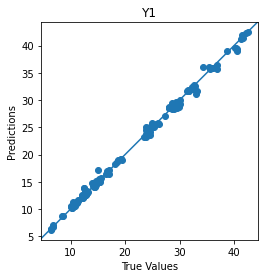

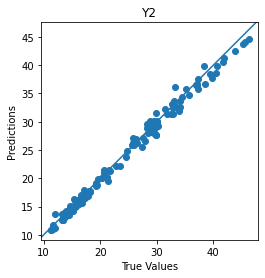

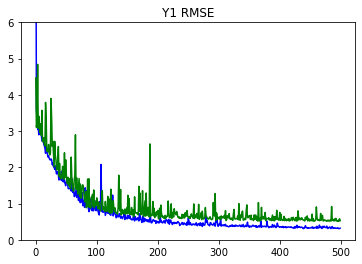

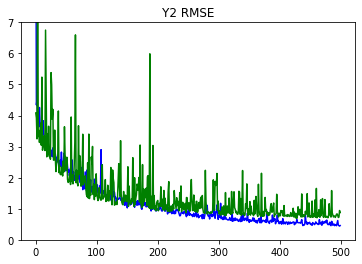

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)